**CMPT353 Project - Stock prediction using machine learning and Deep learning models**

    - Youngseong Kim (301283396)
    - Jieung Park (301330362)
    - Jiwon Jun (301335374)

In [62]:
#Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import os
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import math
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#Set Random seed for LSTM 
tf.random.set_seed(20)
np.random.seed(10)

In [3]:
# Output Template for Machine learning models
OUTPUT_TEMPLATE = (
    'Linear Regression Short/Long Rolling Mean:  {short_rolling_linear:.4f} {long_rolling_linear:.4f}\n'
    'K-nearest Neighbour Regression Short/Long Rolling Mean:  {short_rolling_knn:.4f} {long_rolling_knn:.4f}\n'
    'Random Forest Regression Short/Long Rolling Mean:  {short_rolling_rf:.4f} {long_rolling_rf:.4f}\n'
)

# Set up Data

In [33]:
#Set up data with following aspect: Date, Close_price, Open_price, High_price, Low_price, Adj Price,Trading volume
def getData(data):
    df = pd.read_csv(data)
    return df

#Case #2 Compare indices between nasdaq and nikkei
# data = getData("IXIC.csv")

data = getData("N225.csv")



# Data Cleaning

In [34]:

# Check the percentage of the missing data from the given dataset
# If missing data is less than 5% --> Remove the missing values
# Else --> Impute missing data with midpoint of nearby data

def missing_count(data):
    missing_count = data.isnull().sum() / data.count()
    if missing_count["Adj Close"] < 0.05: 
        data.dropna(inplace=True)
    else:
        data = data.interpolate() # Takes the midpoint between the points
    return data

# Ensure there are no duplicates
def drop_duplicate(data):
    newData = data.drop_duplicates(subset='Date')
    return newData

data = missing_count(data)
data = drop_duplicate(data)



In [35]:
#Test (Deal with data after 1985 ) 
def getDate(data):
    data['Date'] = pd.to_datetime(data['Date'])
    data['year'] = data['Date'].dt.year
    data= data.loc[data['year'] >= 1985]
    return data

data = getDate(data)

data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,year
5216,1985-01-02,11543.000000,11543.000000,11543.000000,11543.000000,11543.000000,0.0,1985
5218,1985-01-04,11558.059570,11558.059570,11558.059570,11558.059570,11558.059570,0.0,1985
5219,1985-01-07,11575.519531,11575.519531,11575.519531,11575.519531,11575.519531,0.0,1985
5220,1985-01-08,11679.790039,11679.790039,11679.790039,11679.790039,11679.790039,0.0,1985
5221,1985-01-09,11763.570313,11763.570313,11763.570313,11763.570313,11763.570313,0.0,1985


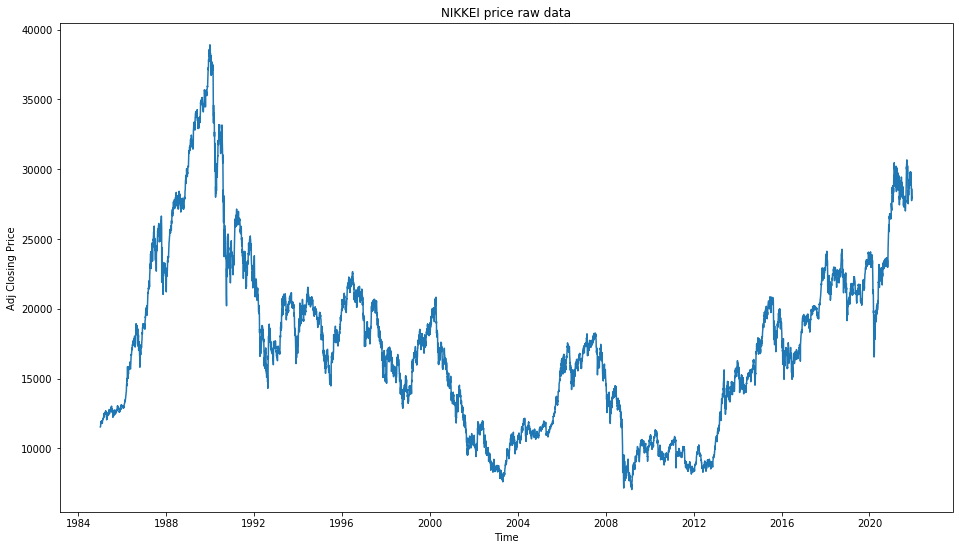

In [36]:
# Graph raw data
def getGraph(data, title):
    plt.figure(figsize=(16, 9))
    plt.plot(data['Date'], data['Adj Close'])
    plt.xlabel('Time')
    plt.ylabel('Adj Closing Price')
    plt.title(title + " price raw data")
#     plt.show()
    plt.savefig('outputImage/'+title+" raw data.png", format="png")

# getGraph(data, "NASDAQ")
getGraph(data, "NIKKEI")


# Noise Filtering

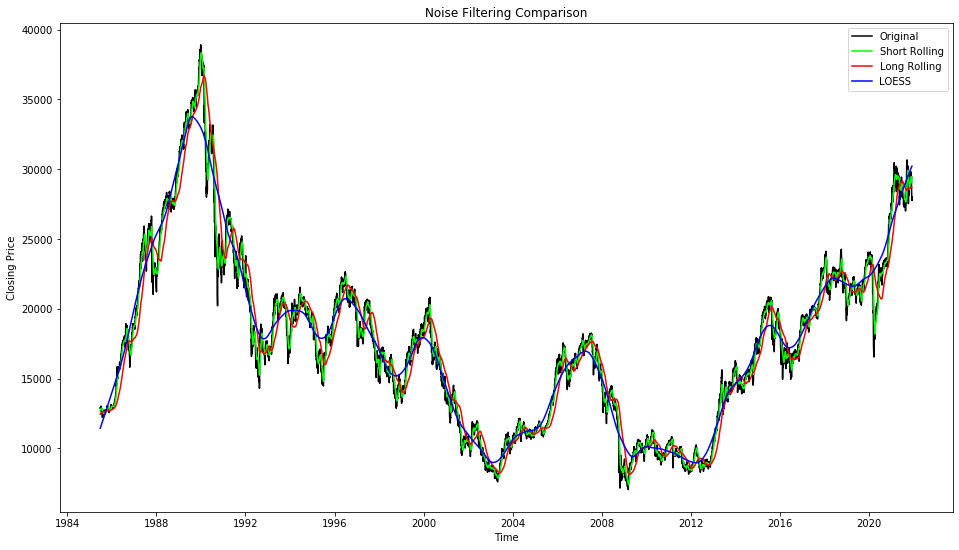

In [37]:
def rolling_mean(data):
    # 1. Rolling mean
    short_data = data
    short_data['short_rolling'] = data['Adj Close'].shift(-1).rolling(window=20).mean()
    short_data.dropna(inplace=True)

    long_data = data
    long_data['long_rolling'] = data['Adj Close'].shift(-1).rolling(window=100).mean()
    long_data.dropna(inplace=True)
    return short_data, long_data

def graph_noise_filter(data):
    plt.figure(figsize=(16, 9))
    plt.plot(data['Date'], data['Adj Close'], color='black', linewidth=1.5)	# Original data
    plt.plot(data['Date'], short_data['short_rolling'], color='lime', label='20-days SMA')
    plt.plot(data['Date'], long_data['long_rolling'], color='red', label='100-days SMA')

    # 2. LOESS
    filtered = lowess(data['Adj Close'], data['Date'], frac=0.05)
    plt.plot(data['Date'], filtered[:, 1], color='blue')

    plt.legend(['Original', 'Short Rolling', 'Long Rolling', 'LOESS'])
    plt.xlabel('Time')
    plt.ylabel('Closing Price')
    plt.title('Noise Filtering Comparison')
    plt.savefig('outputImage/Noise Filtering Comparison.png', format="png")
#     plt.show()
    # plt.savefig('noise_filtering.png')

short_data, long_data = rolling_mean(data)
graph_noise_filter(data)

# Machine Learning: Regression Models

## Linear Regression - Short Rolling

The RMSE is 511.5700564574553
The train score is 0.9946509603904252, The test score is 0.9808844588819139


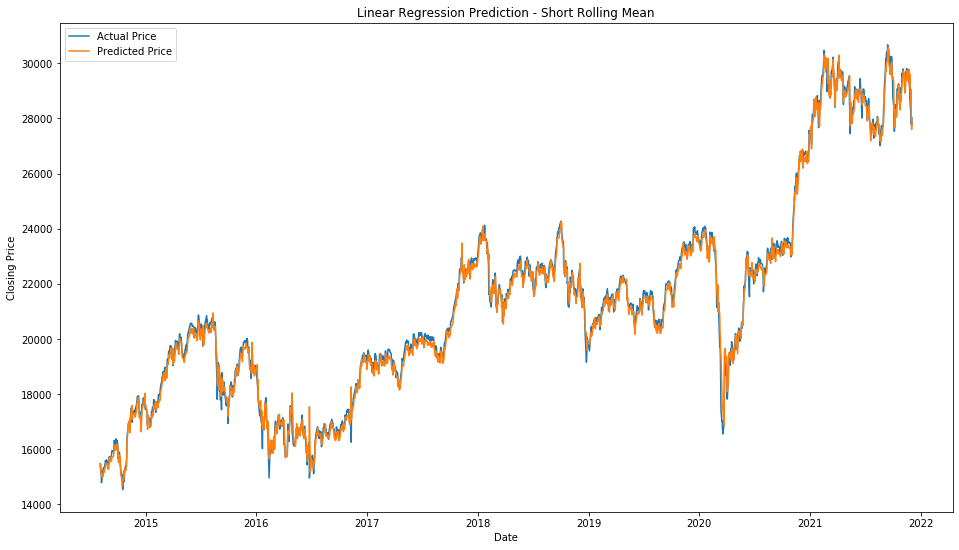

In [38]:
def shortrolling_train_test_split(data):
    X = data[['Open', 'High', 'Low', 'Volume']]
    y_short = short_data['short_rolling']
    t = int(0.8*len(data))
    X_train = X[:t]
    X_test = X[t:]
    y_short_train = y_short[:t]
    y_short_test = y_short[t:]
    return X_train, X_test, y_short_train, y_short_test

X_train, X_test, y_short_train, y_short_test = shortrolling_train_test_split(data)

def short_linear_model(data):
    lin_model = make_pipeline(
        MinMaxScaler(),
        LinearRegression()
    )
    lin_model.fit(X_train, y_short_train)
    predictions = lin_model.predict(X_test) # Predict a model
    train_score = lin_model.score(X_train, y_short_train)
    test_score = lin_model.score(X_test, y_short_test)

    # Making DataFrame for the predictions & Joining
    linear_pred_short = pd.DataFrame(predictions, index=y_short_test.index, columns=['Linear_pred_short'])
    join_pred = data.join(linear_pred_short, how='inner')
    
    
    plt.figure(figsize=(16, 9))
    plt.plot(join_pred['Date'], join_pred['Close'], label='Actual Price')
    plt.plot(join_pred['Date'], join_pred['Linear_pred_short'],  label='Predicted Price')
    plt.title('Linear Regression Prediction - Short Rolling Mean')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend(loc='upper left')
    plt.savefig("outputImage/LinearRegression Prediction - Short Rolling.png", format="png")
#     plt.show()
    
    print("The RMSE is {}".format(math.sqrt(mean_squared_error(y_short_test, predictions))))
    
        
    return train_score, test_score, linear_pred_short

short_linear_train_score, short_linear_test_score, linear_pred_short = short_linear_model(data)




## Linear Regression - Long Rolling

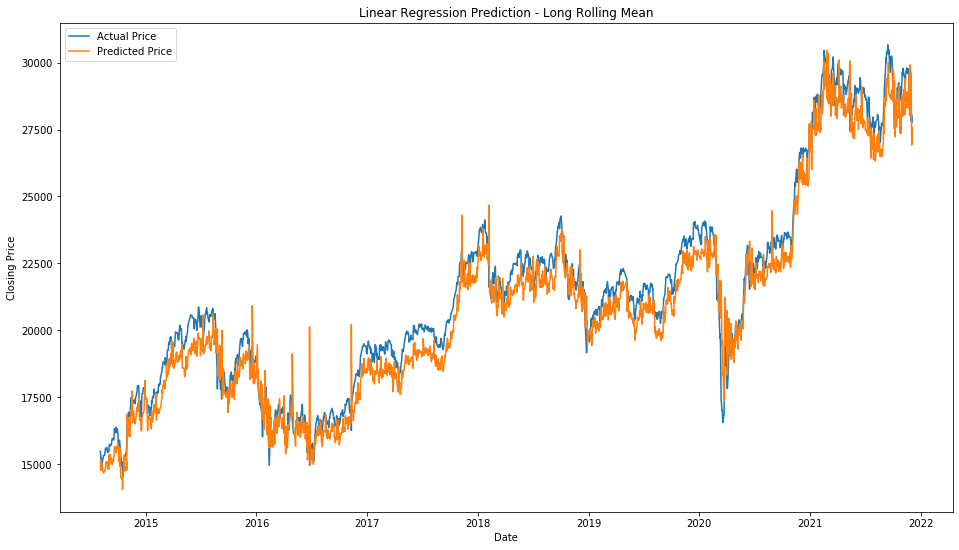

The RMSE is 763.7332770366928
The train score is 0.9657172070877389, The test score is 0.8947416756330229


In [39]:
def longrolling_train_test_split(data):
    X = data[['Open', 'High', 'Low', 'Volume']]
    y_long = long_data['long_rolling']
    t = int(0.8*len(data))
    X_train = X[:t]
    X_test = X[t:]
    y_long_train = y_long[:t]
    y_long_test = y_long[t:]
    return X_train, X_test, y_long_train, y_long_test

X_train, X_test, y_long_train, y_long_test = longrolling_train_test_split(data)

def long_linear_model(data):
    lin_model = make_pipeline(
        MinMaxScaler(),
        LinearRegression()
    )
    lin_model.fit(X_train, y_long_train)
    predictions = lin_model.predict(X_test) # Predict a model
    train_score = lin_model.score(X_train, y_long_train)
    test_score = lin_model.score(X_test, y_long_test)

    # Making DataFrame for the predictions & Joining
    linear_pred_long = pd.DataFrame(predictions, index=y_long_test.index, columns=['Linear_pred_long'])
    join_pred = data.join(linear_pred_long, how='inner')

    plt.figure(figsize=(16, 9))
    plt.plot(join_pred['Date'], join_pred['Close'], label='Actual Price')
    plt.plot(join_pred['Date'], join_pred['Linear_pred_long'],  label='Predicted Price')
    plt.title('Linear Regression Prediction - Long Rolling Mean')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend(loc='upper left')
    plt.savefig("outputImage/LinearRegression Prediction - Long Rolling.png", format="png")
    plt.show()
    
    print("The RMSE is {}".format(math.sqrt(mean_squared_error(y_short_test, predictions))))

    return train_score, test_score, linear_pred_long

long_linear_train_score, long_linear_test_score, linear_pred_long = long_linear_model(data)



## K-nearest Neighbour Regression - Short Rolling

The train score is 0.9960684845119456, The test score is 0.9098067039615594


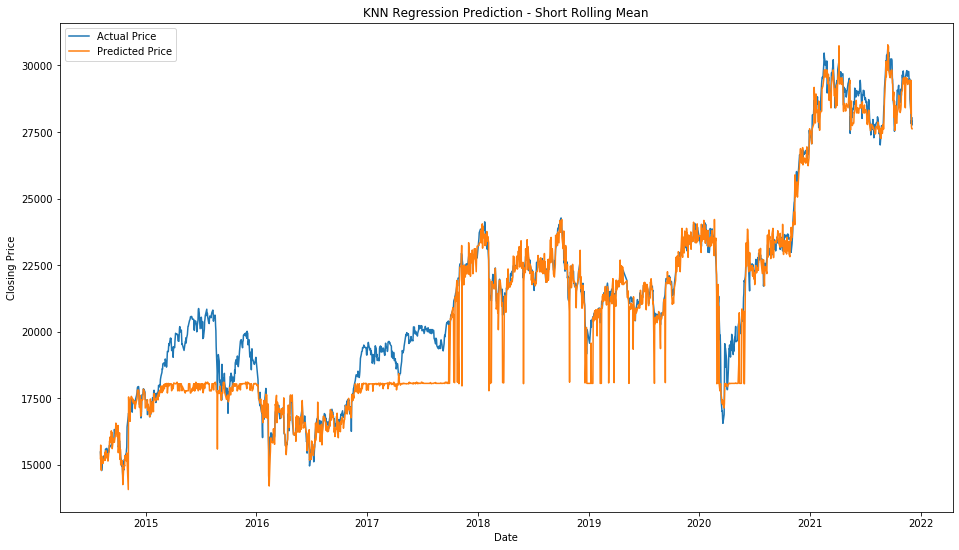

In [40]:
def short_knn_model(data):
    # Training & Test data defined above already
    knn_model = make_pipeline(
        MinMaxScaler(),
        KNeighborsRegressor(n_neighbors=5)
    )
    knn_model.fit(X_train, y_short_train)
    knn_pred = knn_model.predict(X_test) # Predict a model
    train_score = knn_model.score(X_train, y_short_train)
    test_score = knn_model.score(X_test, y_short_test)

    # Making DataFrame for the predictions & Joining
    knn_pred_short = pd.DataFrame(knn_pred, index=y_short_test.index, columns=['Knn_pred_short'])
    join_pred = data.join(knn_pred_short, how='inner')

    plt.figure(figsize=(16, 9))
    plt.plot(join_pred['Date'], join_pred['Close'], label='Actual Price')
    plt.plot(join_pred['Date'], join_pred['Knn_pred_short'], label='Predicted Price')
    plt.title('KNN Regression Prediction - Short Rolling Mean')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend(loc='upper left')
    plt.savefig("outputImage/KNN Regression Prediction - Short Rolling.png", format="png")
#     plt.show()

    return train_score, test_score, knn_pred_short

short_knn_train_score, short_knn_test_score, knn_pred_short = short_knn_model(data)


## K-nearest Neighbour Regression - Long Rolling

The train score is 0.978206698072361, The test score is 0.7019930763143687


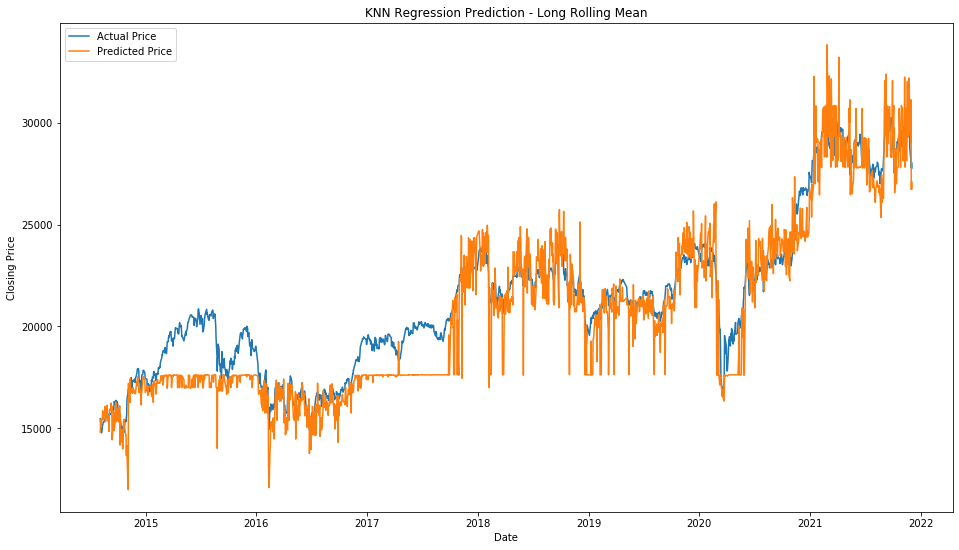

In [41]:
def long_knn_model(data):
    # Training & Test data defined above already
    knn_model = make_pipeline(
        MinMaxScaler(),
        KNeighborsRegressor(n_neighbors=5)
    )
    knn_model.fit(X_train, y_long_train)
    knn_pred = knn_model.predict(X_test) # Predict a model
    train_score = knn_model.score(X_train, y_long_train)
    test_score = knn_model.score(X_test, y_long_test)

    # Making DataFrame for the predictions & Joining
    knn_pred_long = pd.DataFrame(knn_pred, index=y_long_test.index, columns=['Knn_pred_long'])
    join_pred = data.join(knn_pred_long, how='inner')

    plt.figure(figsize=(16, 9))
    plt.plot(join_pred['Date'], join_pred['Close'], label='Actual Price')
    plt.plot(join_pred['Date'], join_pred['Knn_pred_long'], label='Predicted Price')
    plt.title('KNN Regression Prediction - Long Rolling Mean')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend(loc='upper left')
    plt.savefig("outputImage/KNN Regression Prediction - Long Rolling.png", format="png")
#     plt.show()

    return train_score, test_score, knn_pred_long

long_knn_train_score, long_knn_test_score, knn_pred_long = long_knn_model(data)



## Random Forest Regression - Best Parameters

In [42]:
def short_rf_parameters():
    # Short Rolling
    grid = {'n_estimators': [500], 'max_depth': [30], 'min_samples_leaf': [20]}
    test_scores = []

    rf_model = RandomForestRegressor()

    for g in ParameterGrid(grid):
        rf_model.set_params(**g) 
        rf_model.fit(X_train, y_short_train)
        test_scores.append(rf_model.score(X_test, y_short_test))

    best_index = np.argmax(test_scores)
    print(test_scores[best_index], ParameterGrid(grid)[best_index])

def long_rf_parameters():
    # Long Rolling
    grid = {'n_estimators': [500], 'max_depth': [30], 'min_samples_leaf': [20]}
    test_scores = []

    rf_model = RandomForestRegressor()

    for g in ParameterGrid(grid):
        rf_model.set_params(**g) 
        rf_model.fit(X_train, y_long_train)
        test_scores.append(rf_model.score(X_test, y_long_test))

    best_index = np.argmax(test_scores)
    print(test_scores[best_index], ParameterGrid(grid)[best_index])

short_rf_parameters()
long_rf_parameters()

0.9742975557233803 {'n_estimators': 500, 'min_samples_leaf': 20, 'max_depth': 30}
0.7475549614304361 {'n_estimators': 500, 'min_samples_leaf': 20, 'max_depth': 30}


## Random Forest Regression - Short Rolling

The train score is 0.9950748388821014, The test score is 0.9732944501383977


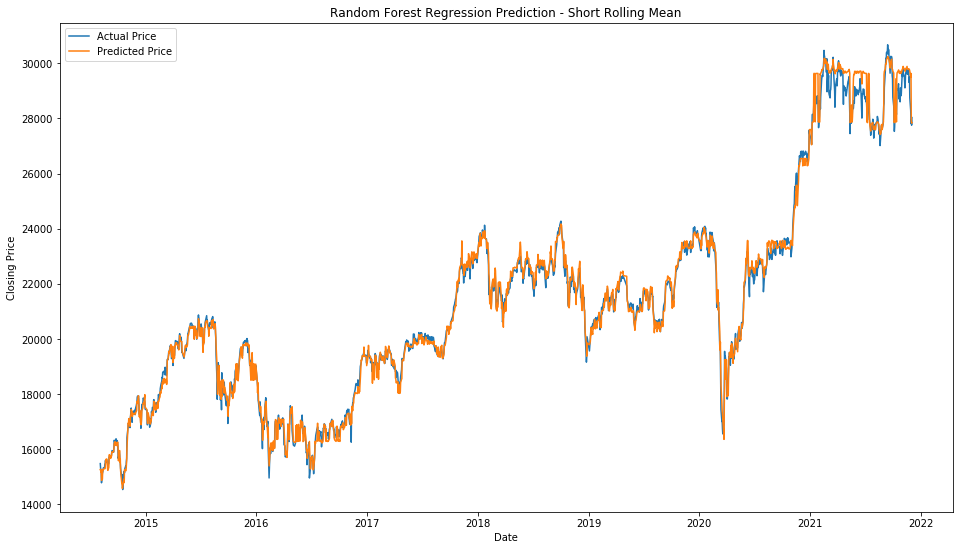

In [43]:
def short_rf_model(data):
    # Training & Test data defined above already
    rf_model = make_pipeline(
        MinMaxScaler(),
        RandomForestRegressor(n_estimators=500, max_depth=20, min_samples_leaf=30)
    )
    rf_model.fit(X_train, y_short_train)
    rf_pred = rf_model.predict(X_test) # Predict a model
    train_score = rf_model.score(X_train, y_short_train) 
    test_score = rf_model.score(X_test, y_short_test) 

    # Making DataFrame for the predictions & Joining
    rf_pred_short = pd.DataFrame(rf_pred, index=y_short_test.index, columns=['rf_pred_short'])
    join_pred = data.join(rf_pred_short, how='inner')

    plt.figure(figsize=(16, 9))
    plt.plot(join_pred['Date'], join_pred['Close'], label='Actual Price')
    plt.plot(join_pred['Date'], join_pred['rf_pred_short'], label='Predicted Price')
    plt.title('Random Forest Regression Prediction - Short Rolling Mean')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend(loc='upper left')
    plt.savefig("outputImage/Random Forest Regression Prediction - Short Rolling.png", format="png")
#     plt.show()

    return train_score, test_score, rf_pred_short

short_rf_train_score, short_rf_test_score, rf_pred_short = short_rf_model(data)




## Random Forest Regression - Long Rolling

The train score is 0.9704150802251126, The test score is 0.7392391859415062


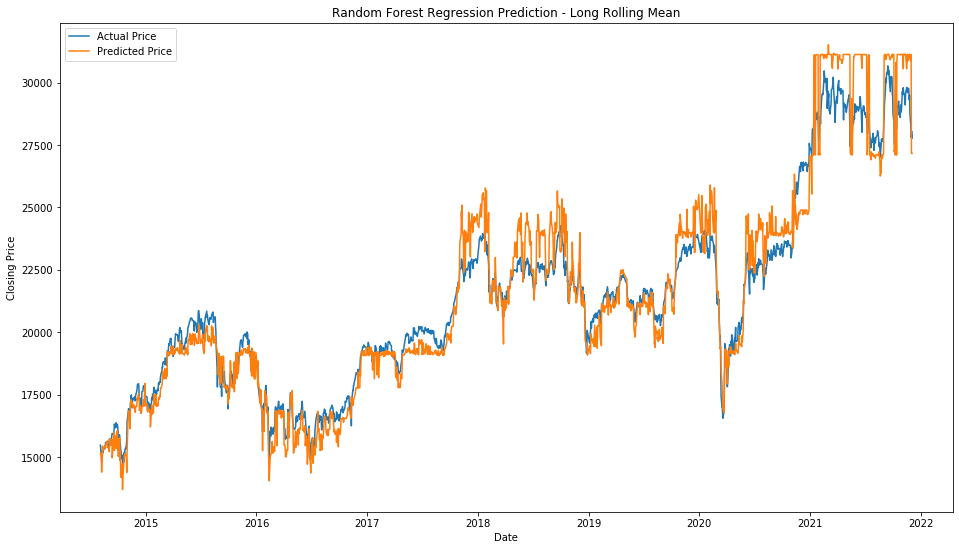

In [44]:
def long_rf_model(data):
    # Training & Test data defined above already
    rf_model = make_pipeline(
        MinMaxScaler(),
        RandomForestRegressor(n_estimators=500, max_depth=20, min_samples_leaf=30)
    )
    rf_model.fit(X_train, y_long_train)
    rf_pred = rf_model.predict(X_test) # Predict a model
    train_score = rf_model.score(X_train, y_long_train) # Short - 0.997828, Long - 0.987426
    test_score = rf_model.score(X_test, y_long_test) # Short - 0.992788, Long - 0.966242

    # Making DataFrame for the predictions & Joining
    rf_pred_long = pd.DataFrame(rf_pred, index=y_long_test.index, columns=['rf_pred_long'])
    join_pred = data.join(rf_pred_long, how='inner')

    plt.figure(figsize=(16, 9))
    plt.plot(join_pred['Date'], join_pred['Close'], label='Actual Price')
    plt.plot(join_pred['Date'], join_pred['rf_pred_long'], label='Predicted Price')
    plt.title('Random Forest Regression Prediction - Long Rolling Mean')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend(loc='upper left')
    plt.savefig("outputImage/Random Forest Regression Prediction - Long Rolling.png", format="png")
#     plt.show()

    return train_score, test_score, rf_pred_long

long_rf_train_score, long_rf_test_score, rf_pred_long = long_rf_model(data)




In [45]:
# Printing machine learning train/test scores
print(OUTPUT_TEMPLATE.format(
    short_rolling_linear = short_linear_test_score,
    long_rolling_linear = long_linear_test_score,
    short_rolling_knn = short_knn_test_score, 
    long_rolling_knn = long_knn_test_score, 
    short_rolling_rf = short_rf_test_score, 
    long_rolling_rf = long_rf_test_score,
))

Linear Regression Short/Long Rolling Mean:  0.9809 0.8947
K-nearest Neighbour Regression Short/Long Rolling Mean:  0.9098 0.7020
Random Forest Regression Short/Long Rolling Mean:  0.9733 0.7392



## Machine Learning Models Failure Analysis

In [46]:
# Print the descriptive statistics of each model to check the range

def model_statistic():
    linear_range = linear_pred_short.describe()
    knn_range = knn_pred_short.describe()
    rf_range = rf_pred_short.describe()
    
    model_stats = pd.merge(linear_range, knn_range, left_index=True, right_index=True)
    model_stats = model_stats.merge(rf_range, left_index=True, right_index=True)
    model_stats = model_stats.rename(
        columns={"Linear_pred_short": "Linear_Regression", 
                 "Knn_pred_short": "KNN", 
                 "rf_pred_short": "Random_Forest"})
    
    return model_stats

model_stats = model_statistic()
print(model_stats)

       Linear_Regression           KNN  Random_Forest
count        1792.000000   1792.000000    1792.000000
mean        21226.263998  20787.878866   21357.732957
std          3722.631725   3933.190122    3861.786912
min         14672.486469  14064.518818   14573.727996
25%         18783.344292  17853.027266   18533.636967
50%         20873.897100  20559.030313   20952.208561
75%         22770.949329  23010.748975   23090.672170
max         30566.087845  30777.082891   30243.331164


In [47]:
# Print the descriptive statistics of original data for comparison

def data_statistic(data):
    data_range = data['short_rolling'].describe()
    train_data_range = y_short_train.describe()

    original_stats = pd.DataFrame({
        'raw_data': data_range,
        'train_data': train_data_range,
    })
    
    return original_stats

original_stats = data_statistic(data)
print(original_stats)

           raw_data    train_data
count   8956.000000   7164.000000
mean   17590.804135  16674.772412
std     6258.158681   6429.867095
min     7384.125000   7384.125000
25%    12747.448914  11294.144946
50%    17120.300537  16081.344263
75%    21005.912402  19929.425952
max    38345.544922  38345.544922


# Deep Learning - LSTM

## Data Pre-processing

In [48]:
closePriceShort = short_data['short_rolling'].astype("float32")

traingingSetSize = int(len(short_data)*0.8)
training_set = short_data.iloc[:traingingSetSize, 8:9].values #short_rolling
test_set = short_data.iloc[traingingSetSize:, 8:9].values #short_rolling

test_date = short_data.iloc[traingingSetSize:, 0]




## Date Normalization

In [49]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, traingingSetSize):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


## Build Model 

In [60]:
epochs = 20

model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
#Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')


# Fitting the RNN to the Training set
history = model.fit(X_train, y_train, epochs = epochs, batch_size = 64, validation_split=0.1)
model.summary() 


Train on 6393 samples, validate on 711 samples
Epoch 1/20
6393/6393 [==============================] - 9s 1ms/sample - loss: 0.0075 - val_loss: 2.4695e-04
Epoch 2/20
6393/6393 [==============================] - 3s 413us/sample - loss: 0.0018 - val_loss: 1.9680e-04
Epoch 3/20
6393/6393 [==============================] - 2s 369us/sample - loss: 0.0017 - val_loss: 1.8022e-04
Epoch 4/20
6393/6393 [==============================] - 3s 394us/sample - loss: 0.0016 - val_loss: 2.9685e-04
Epoch 5/20
6393/6393 [==============================] - 2s 380us/sample - loss: 0.0013 - val_loss: 1.4747e-04
Epoch 6/20
6393/6393 [==============================] - 2s 356us/sample - loss: 0.0013 - val_loss: 1.7532e-04
Epoch 7/20
6393/6393 [==============================] - 2s 328us/sample - loss: 0.0012 - val_loss: 1.3355e-04
Epoch 8/20
6393/6393 [==============================] - 2s 324us/sample - loss: 0.0010 - val_loss: 1.3080e-04
Epoch 9/20
6393/6393 [==============================] - 2s 343us/sample - l

## Ready for Test data set

In [56]:

dataset_train = short_data.iloc[:traingingSetSize, 8:9]
dataset_test = short_data.iloc[traingingSetSize: , 8:9]


dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
y_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])
    y_test.append(inputs[i, 0])
    
X_test = np.array(X_test)
y_test = np.array(y_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

## Model prediction and Visualizing the results

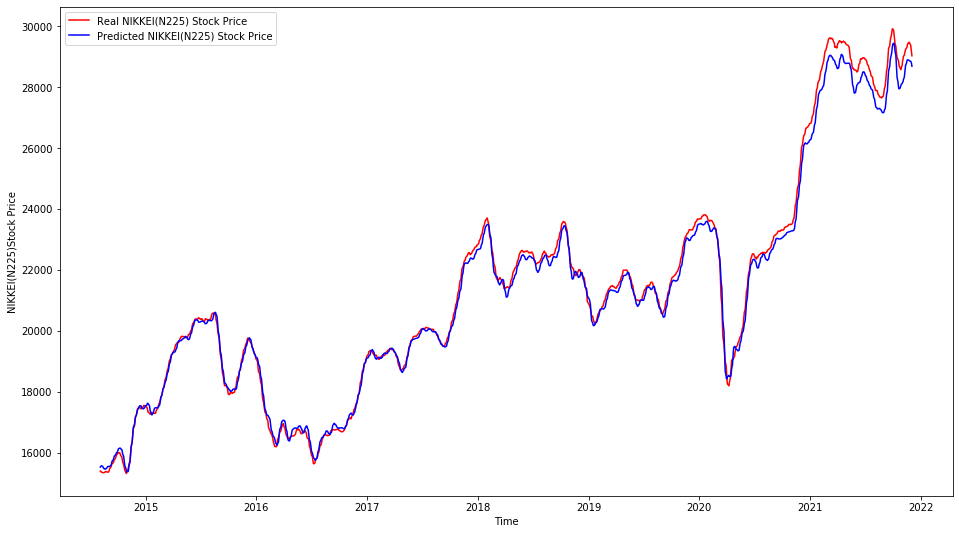

In [57]:
# Visualising the results

predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
testY = sc.inverse_transform([y_test])

def getGraph(epochs, Indicetype):
    plt.figure(figsize=(16,9))
    plt.plot(test_date,dataset_test.values, color = "red", label = "Real "+Indicetype+" Stock Price")
    plt.plot(test_date,predicted_stock_price, color = "blue", label = "Predicted "+Indicetype+" Stock Price")
    plt.xlabel('Time')
    plt.ylabel(Indicetype +"Stock Price")
    plt.legend()
    plt.savefig("outputImage/LSTM_"+Indicetype+'_'+str(epochs)+".png", format="png")

getGraph(epochs, "NIKKEI(N225)")



## Analysis

In [58]:
#To get RMSE

import math
from sklearn.metrics import mean_squared_error

testScore = math.sqrt(mean_squared_error(testY[0],predicted_stock_price[:,0] ))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 266.30 RMSE


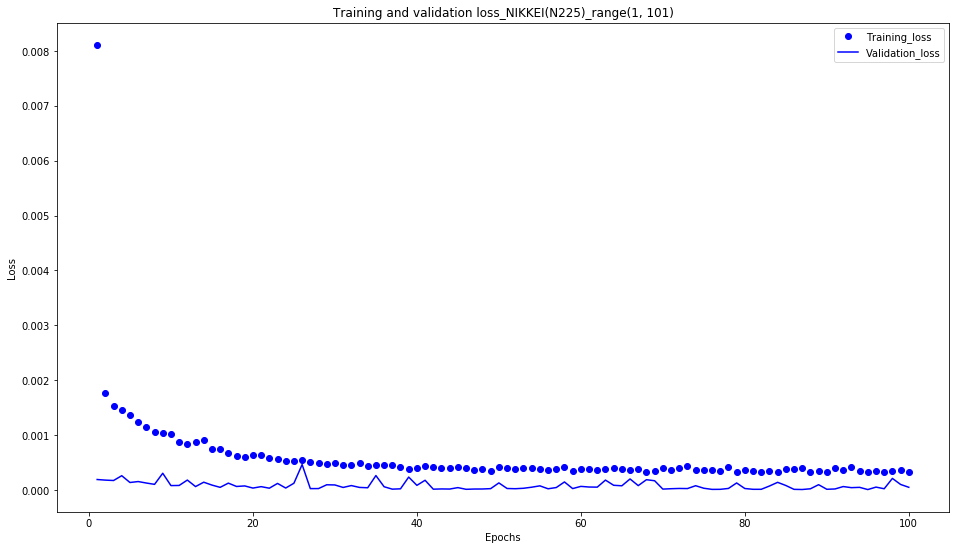

In [59]:
#Validation loss and training loss 
def getLoss(epochs,Indicetype):
    
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(loss)+1)
    plt.figure(figsize=(16,9))
    plt.plot(epochs, loss, "bo", label = "Training_loss")
    plt.plot(epochs, val_loss, "b", label = "Validation_loss")
    plt.title("Training and validation loss_"+Indicetype+"_"+str(epochs))
    plt.legend()
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.savefig("outputImage/LSTM_LOSS"+Indicetype+'_'+str(epochs)+".png", format="png")
#     plt.show()

getLoss(epochs, "NIKKEI(N225)")




## Initial Model with single hidden layer 
- Used it as first model

In [24]:
# closePriceShort = short_data['short_rolling'].astype("float32")
# closePriceLong = long_data["long_rolling"].astype("float32")
# train_Short = closePriceShort[0:int(len(closePriceShort)*0.8)]
# train_Long = closePriceLong[0:int(len(closePriceLong)*0.8)]


In [99]:
# # LSTM Data normalization
# #We have to sacle our data for optimal performance
# sc = MinMaxScaler(feature_range = (-1,1))
# training_set_scaled = sc.fit(train_Short.values.reshape(-1,1))
# closePrice = sc.transform(closePriceShort.values.reshape(-1,1))





In [100]:
# '''
# Our train data will have as features the look back values, which are the lag values noted as ‘lb’.
# For this example, we set the lb equal to 10. Notice that we scale the data on the “train” dataset
# using the MinMaxScaler() from scikit-learn. Finally, for this example, we keep as train dataset
# the first 80% of the observations and as a test dataset the rest 20%
# '''
# def processData(data,lag):
#     X,Y = [],[]
#     for i in range(len(data)-lag-1):
#         X.append(data[i:(i+lag),0])
#         Y.append(data[(i+lag),0])
#     return np.array(X),np.array(Y)

# lag=10
# X,y = processData(closePrice,lag)
# X,y = processData(closePrice,lag)
# X_train,X_test = X[:int(X.shape[0]*0.80)],X[int(X.shape[0]*0.80):]
# y_train,y_test = y[:int(y.shape[0]*0.80)],y[int(y.shape[0]*0.80):]
# print(X_train.shape[0],X_train.shape[1])
# print(X_test.shape[0], X_test.shape[1])
# print(y_train.shape[0])
# print(y_test.shape[0])


7342 10
1836 10
7342
1836


### Train models

In [84]:

# epochs = 150
# #Need to install Tensorflow
# #pip install --upgrade tensorflow
# #pip install keras
# model = Sequential()
# model.add(LSTM(256,input_shape=(lag,1)))
# model.add(Dense(1,))
# model.compile(optimizer='adam',loss='mse')

# #Reshape data for (Sample,Timestep,Features) 
# X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
# X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
# #Fit model with history to check for overfitting
# history = model.fit(X_train,y_train,epochs=epochs,validation_data=(X_test,y_test),shuffle=False)
# model.summary() 


### Train

In [25]:
# plt.figure(figsize=(12,8))

# Xt = model.predict(X_train)
# traingingSetSize = int(len(short_data)*0.8)
# test_date = short_data.iloc[traingingSetSize+3:, 0]

# plt.plot(sc.inverse_transform(y_train.reshape(-1,1)),label="Actual")
# plt.plot(sc.inverse_transform(Xt),label="Predicted")
# plt.legend()
# plt.title("Train Dataset with epochs " + str(epochs), fontsize=20)

### Test

In [26]:
# plt.figure(figsize=(12,8))

# Xt = model.predict(X_test)

# plt.plot(sc.inverse_transform(y_test.reshape(-1,1)),label="Actual")
# plt.plot(sc.inverse_transform(Xt),label="Predicted")
# plt.legend()
# plt.title("Test Dataset with epochs "+ str(epochs), fontsize=20)

In [27]:
# #To get RMSE

# import math
# from sklearn.metrics import mean_squared_error

# testScore = math.sqrt(mean_squared_error(testY[0],predicted_stock_price[:,0] ))
# print('Test Score: %.2f RMSE' % (testScore))

In [28]:
# #Validation loss and training loss 
# loss = history.history["loss"]
# val_loss = history.history["val_loss"]
# epochs = range(1, len(loss)+1)
# plt.figure(figsize=(16,9))
# plt.plot(epochs, loss, "bo", label = "Training_loss")
# plt.plot(epochs, val_loss, "b", label = "Validation_loss")
# plt.title("Training and validation loss")
# plt.legend()
# plt.xlabel
# plt.show()